<a href="https://colab.research.google.com/github/sum-iit/Deploy_Model/blob/main/ICASSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup (install + imports)

In [28]:
!pip install scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import math
import random
from typing import List, Tuple

Define helpers (loss, grad, prox, etc.)

In [29]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss_and_grad_binary(w: np.ndarray, X: np.ndarray, y: np.ndarray):
    n = X.shape[0]
    z = X.dot(w)
    p = sigmoid(z)
    eps = 1e-12
    loss = - np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    grad = X.T.dot(p - y) / float(n)
    return loss, grad

def objective_F_binary(w: np.ndarray, X: np.ndarray, y: np.ndarray, lam: float):
    loss, _ = logistic_loss_and_grad_binary(w, X, y)
    return loss + lam * np.linalg.norm(w, ord=1)

def soft_thresholding(u: np.ndarray, thresh: float):
    return np.sign(u) * np.maximum(np.abs(u) - thresh, 0.0)


Inner solver: batch optimum (prox-grad)

In [30]:
def compute_batch_optimum_binary(X_batch: np.ndarray,
                                 y_batch: np.ndarray,
                                 lam: float,
                                 w_init: np.ndarray = None,
                                 max_iter: int = 500,
                                 eta: float = 1e-2,
                                 tol: float = 1e-6) -> Tuple[np.ndarray, List[float]]:
    n_features = X_batch.shape[1]
    if w_init is None:
        w = np.zeros(n_features)
    else:
        w = w_init.copy()
    objs = []
    for it in range(max_iter):
        loss, grad = logistic_loss_and_grad_binary(w, X_batch, y_batch)
        u = w - eta * grad
        w_new = soft_thresholding(u, eta * lam)
        obj = loss + lam * np.linalg.norm(w_new, ord=1)
        objs.append(obj)
        if np.linalg.norm(w_new - w) < tol:
            w = w_new
            break
        w = w_new
    return w, objs

Create batches with similarity

In [31]:
def make_batches_with_similarity(X: np.ndarray,
                                 y: np.ndarray,
                                 batch_size: int,
                                 similarity: float,
                                 random_state: int = None) -> List[Tuple[np.ndarray, np.ndarray]]:
    assert 0.0 <= similarity <= 1.0
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    indices = np.arange(n)
    rng.shuffle(indices)
    pool = list(indices)
    batches = []
    prev_batch_idx = None
    num_batches_est = max(1, math.ceil(n / batch_size) * 3)

    for b in range(num_batches_est):
        if prev_batch_idx is None:
            batch_idx = []
            while len(batch_idx) < batch_size:
                if not pool:
                    pool = list(indices)
                    rng.shuffle(pool)
                batch_idx.append(pool.pop())
            prev_batch_idx = batch_idx
        else:
            num_shared = int(round(similarity * batch_size))
            shared_idx = rng.choice(prev_batch_idx, size=num_shared, replace=False).tolist() if num_shared > 0 else []
            needed = batch_size - len(shared_idx)
            new_idx = []
            while len(new_idx) < needed:
                if not pool:
                    pool = list(indices)
                    rng.shuffle(pool)
                new_idx.append(pool.pop())
            batch_idx = shared_idx + new_idx
            prev_batch_idx = batch_idx
        batch_idx = np.array(batch_idx, dtype=int)
        batches.append((X[batch_idx], y[batch_idx]))
    return batches

MNIST loader (binary: digit_a vs digit_b)

In [32]:
def load_mnist_binary(digit_a: int = 3, digit_b: int = 6, max_samples_per_class: int = None, rng_seed: int = 0):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X_all = mnist['data'].astype(np.float32)
    y_all_str = mnist['target']
    labels = np.array([int(x) for x in y_all_str])
    mask = (labels == digit_a) | (labels == digit_b)
    X = X_all[mask]
    y = labels[mask]
    y = (y == digit_b).astype(int)  # digit_b → 1, digit_a → 0

    if max_samples_per_class is not None:
        rng = np.random.default_rng(rng_seed)
        idx0 = np.where(y == 0)[0]
        idx1 = np.where(y == 1)[0]
        choose0 = rng.choice(idx0, size=min(len(idx0), max_samples_per_class), replace=False)
        choose1 = rng.choice(idx1, size=min(len(idx1), max_samples_per_class), replace=False)
        chosen = np.concatenate([choose0, choose1])
        X = X[chosen]
        y = y[chosen]

    X = X / 255.0
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)

    feature_names = [f"px{i}" for i in range(X.shape[1])]
    return X, y, feature_names

OPG experiment (per similarity regime)

In [33]:
def run_opg_experiment_mnist(similarity: float,
                             batch_size: int = 500,
                             lam: float = 1e-3,
                             eta_opg: float = 0.1,
                             n_rounds: int = None,
                             random_state: int = 0,
                             digit_a: int = 3,
                             digit_b: int = 6,
                             max_samples_per_class: int = 30000):
    np.random.seed(random_state)
    random.seed(random_state)

    X, y, feature_names = load_mnist_binary(digit_a=digit_a, digit_b=digit_b,
                                           max_samples_per_class=max_samples_per_class,
                                           rng_seed=random_state)
    n_samples, n_features = X.shape

    batches = make_batches_with_similarity(X, y, batch_size=batch_size, similarity=similarity, random_state=random_state)
    if n_rounds is None:
        n_rounds = len(batches)
    else:
        n_rounds = min(n_rounds, len(batches))

    w = np.zeros(n_features)
    w_prev = w.copy()

    dynamic_regrets = []
    cumulative_dynamic_regrets = []
    cumulative_regret = 0.0

    w_star_prev = None
    F_star_prev = None
    V_list, V_star_list, S_list = [], [], []

    for t in range(n_rounds):
        X_batch, y_batch = batches[t]
        # OPG update
        loss, grad = logistic_loss_and_grad_binary(w, X_batch, y_batch)
        u = w - eta_opg * grad
        w_new = soft_thresholding(u, eta_opg * lam)
        w_t = w_new.copy()

        # compute batch optimum
        w_star_t, _ = compute_batch_optimum_binary(X_batch, y_batch, lam=lam, w_init=w_t, max_iter=400, eta=1e-2, tol=1e-6)

        # regrets
        F_wt = objective_F_binary(w_t, X_batch, y_batch, lam)
        F_wt_star = objective_F_binary(w_star_t, X_batch, y_batch, lam)
        regret_t = F_wt - F_wt_star
        cumulative_regret += regret_t
        dynamic_regrets.append(regret_t)
        cumulative_dynamic_regrets.append(cumulative_regret)

        # function variation terms
        if t == 0:
            V_t, V_t_star = 0.0, 0.0
        else:
            X_prev, y_prev = batches[t-1]
            diffs = []
            for cw in [w_prev, w_t, w_star_prev, w_star_t]:
                if cw is None: continue
                Ft = objective_F_binary(cw, X_batch, y_batch, lam)
                Ft_1 = objective_F_binary(cw, X_prev, y_prev, lam)
                diffs.append(abs(Ft - Ft_1))
            V_t = float(max(diffs)) if diffs else 0.0
            V_t_star = abs(F_wt_star - F_star_prev) if F_star_prev is not None else 0.0

        S_t_plus1 = V_t + V_t_star
        V_list.append(V_t)
        V_star_list.append(V_t_star)
        S_list.append(S_t_plus1)

        w_prev = w_t.copy()
        w = w_t.copy()
        w_star_prev = w_star_t.copy()
        F_star_prev = F_wt_star

    return {
        "similarity": similarity,
        "cumulative_dynamic_regrets": cumulative_dynamic_regrets,
        "S_list": S_list
    }

Main experiment: run and plot

In [34]:
def main_experiment_mnist():
    batch_size = 500
    lam = 1e-3
    eta_opg = 0.1
    random_state = 42
    digit_a, digit_b = 3, 6
    max_samples_per_class = 5000  # keeps experiment light for Colab

    results_50 = run_opg_experiment_mnist(similarity=0.5,
                                          batch_size=batch_size,
                                          lam=lam,
                                          eta_opg=eta_opg,
                                          random_state=random_state,
                                          digit_a=digit_a,
                                          digit_b=digit_b,
                                          max_samples_per_class=max_samples_per_class)
    results_90 = run_opg_experiment_mnist(similarity=0.9,
                                          batch_size=batch_size,
                                          lam=lam,
                                          eta_opg=eta_opg,
                                          random_state=random_state + 1,
                                          digit_a=digit_a,
                                          digit_b=digit_b,
                                          max_samples_per_class=max_samples_per_class)

    cum_50 = np.array(results_50["cumulative_dynamic_regrets"])
    cum_90 = np.array(results_90["cumulative_dynamic_regrets"])
    t_axis_50 = np.arange(1, len(cum_50) + 1)
    t_axis_90 = np.arange(1, len(cum_90) + 1)

    plt.figure(figsize=(10,6))
    plt.plot(t_axis_50, cum_50, label="50% similarity", linewidth=2)
    plt.plot(t_axis_90, cum_90, label="90% similarity", linewidth=2)
    plt.xlabel("Round t")
    plt.ylabel("Cumulative Dynamic Regret")
    plt.title(f"Cumulative Dynamic Regret vs Round (MNIST digits {digit_a} vs {digit_b})")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(1, len(results_50["S_list"]) + 1), results_50["S_list"], label="S_t (50% sim)")
    plt.plot(np.arange(1, len(results_90["S_list"]) + 1), results_90["S_list"], label="S_t (90% sim)")
    plt.xlabel("Round t")
    plt.ylabel("Approximate S_t = V_t + V_t^*")
    plt.title("Approximate Function Variation per Round (MNIST)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_50, results_90

Run in Colab

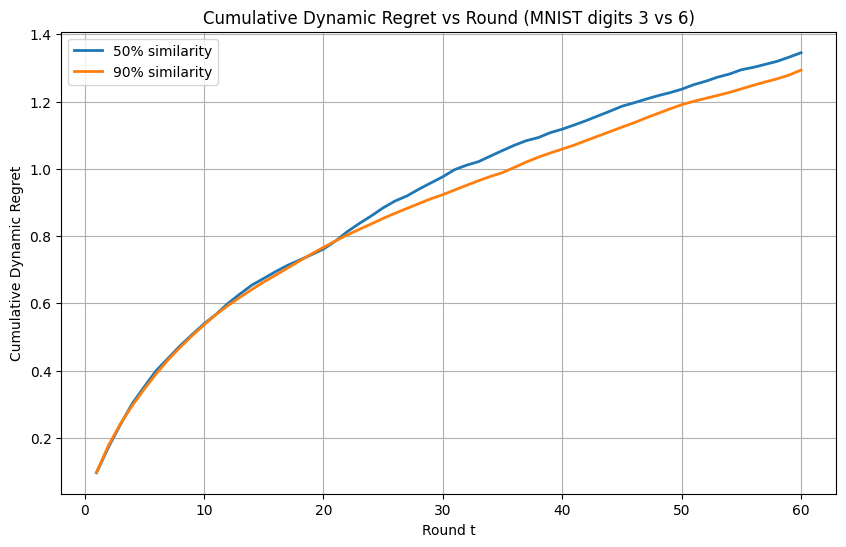

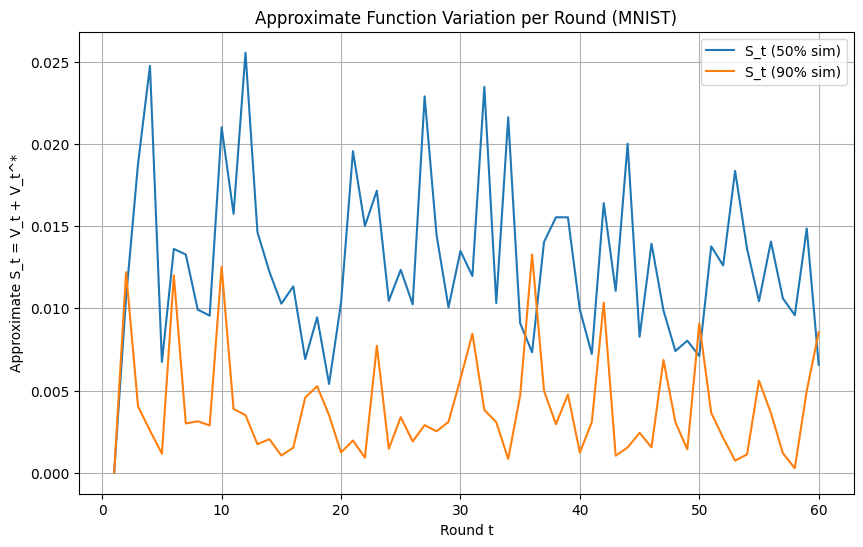

In [35]:
results_50, results_90 = main_experiment_mnist()